# Introduction/Business Problem

Buckinghamshire is a county in England north-west of Greater London. The local authority for the county is Buckinghamshire Council. The Council has a public health department, responsible for improving the overall health of its population.

The department has funding to build and run a fitness and nutrition centre to encourage exercise and healthier diets, which in turn will prevent poor health. The department wishes to locate the most appropriate location for this fitness and nutrition centre. The criteria for finding the most appropriate location should take into account rates of obesity, poverty and the presence of services that encourage healthy or less-healthy behaviours.

# Data

For this problem, I will define a location using the ‘ward’ boundaries across Buckinghamshire. Wards are small geographical regions that each represent a neighbourhood. I will be using three datasets that will help me identify a shortlist for the most appropriate location, or ward, for the fitness and nutrition centre.

The first dataset I will use can be found using Public Health England’s Fingertips API and covers the Index of Multiple Deprivation (IMD) score for each ward in England, which is a measure of poverty. The higher the IMD score, the higher prevalence of poverty there is in a ward.

The second dataset I will use is the rate of obesity among Year 6 age children by ward, which is also provided by the Fingertips API. Currently there is no publicly-available measure for obesity among adults at ward level, so this is the next most relevant proxy for measuring obesity.

The third dataset I will use will be provided by the Foursquare API. This will be used to identify the presence of services that encourage healthy behaviours, such as gyms or leisure centres, and services that encourage less-healthy behaviours, such as fast-food restaurants.

Using this data, I will group all wards in Buckinghamshire using k-means clustering, with the idea that the clusters produced may be able to provide a shortlist of potential locations for the centre. According to this approach, the most ideal location for the centre would be a ward from a cluster that has a relatively high average IMD score, high average rate of obesity among Year 6 age children, with few healthy services and a high number of unhealthy services.

# Methodology

### Retrieving the geographical data

The Public Health England Fingertips API provides obesity and poverty data at ward level, but first we need the list of all wards in Buckinghamshire, along with their geographical coordinates that I will need for the Foursquare API later. Ward data can be extracted using the [ONS Geography Portal](https://geoportal.statistics.gov.uk/).

In [1]:
import pandas as pd
import json
import requests

In [2]:
url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/WD20_LAD20_UK_LU/FeatureServer/0/query?where=LAD20NM%20%3D%20'BUCKINGHAMSHIRE'&outFields=*&outSR=4326&f=json"
r = requests.get(url)
x = r.json()

In [3]:
df = pd.json_normalize(x, 'features')

In [4]:
wards_df = df[['attributes.WD20CD','attributes.WD20NM']]
wards_df.columns = ['Ward ID', 'Ward Name']

Data including geographical coordinates I had to download directly from the portal, then merge it with my wards dataframe.

In [5]:
geo_df = pd.read_csv('Wards_(December_2020)_UK_BFC_V2.csv')
geo_df = geo_df[['WD20CD','LONG','LAT']]
geo_df.columns = ['Ward ID','longitude','latitude']

In [6]:
bucks_df = pd.merge(wards_df,geo_df)
bucks_df

,Ward ID,Ward Name,longitude,latitude
0,E05002636,"Ballinger, South Heath and Chartridge",-0.67319,51.71306
1,E05010335,Buckingham South,-0.97332,51.99219
2,E05010336,Central & Walton,-0.80040,51.81117
3,E05010337,Coldharbour,-0.83723,51.81315
4,E05002637,Central,-0.54285,51.60405
...,...,...,...,...
93,E05010575,Gerrards Cross,-0.56235,51.58500
94,E05010576,Iver Heath,-0.51430,51.53985
95,E05010577,Iver Village & Richings Park,-0.52161,51.51195
96,E05010578,Stoke Poges,-0.58652,51.54336


I then visualised these wards using Folium.

In [ ]:
!pip install folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

In [59]:
# create map of New York using latitude and longitude values
map_bucks = folium.Map(location=[51.7619, -0.8], zoom_start=10)

# add markers to map
for lat, lng, ward in zip(bucks_df['latitude'], bucks_df['longitude'], bucks_df['Ward Name']):
    label = '{}'.format(ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucks)  
    
map_bucks

### Retrieving the data on poverty

Next, I extracted data on poverty, this time using the PHE Fingertips API to extract data on IMD scores by ward.

In [7]:
!pip install fingertips_py
import fingertips_py as ftp

In [8]:
IMD_df = ftp.retrieve_data.get_all_data_for_indicators(indicators='93275', area_type_id='8', filter_by_area_codes=None, is_test=False)
IMD_df = IMD_df[['Area Code','Value']]

In [9]:
IMD_df.columns = ['Ward ID','IMD score']

### Retrieving the data on obesity

I used the same API to extract data on the rate of overweight Year 6 aged children per ward.

In [10]:
weight_df = ftp.retrieve_data.get_all_data_for_indicators(indicators='93108', area_type_id='8', filter_by_area_codes=None, is_test=False)

C:\Users\willi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [11]:
weight_df = weight_df.loc[weight_df['Time period'] == '2017/18 - 19/20']

In [12]:
weight_df = weight_df[['Area Code','Value']]
weight_df.columns = ['Ward ID','Excess weight rate']

### Obesity and poverty - preliminary data exploration

Having extracted the initial data for each of the Buckinghamshire wards, I can now see if there is any surface-level relationship between obesity and poverty. To do this, I will first need to merge all the data into one dataframe.

In [13]:
merged_df = pd.merge(bucks_df,IMD_df)
merged_df = pd.merge(merged_df,weight_df)
merged_df

,Ward ID,Ward Name,longitude,latitude,IMD score,Excess weight rate
0,E05002636,"Ballinger, South Heath and Chartridge",-0.67319,51.71306,7.687,15.4
1,E05010335,Buckingham South,-0.97332,51.99219,5.163,26.3
2,E05010336,Central & Walton,-0.80040,51.81117,12.502,33.3
3,E05010337,Coldharbour,-0.83723,51.81315,9.723,35.4
4,E05002637,Central,-0.54285,51.60405,4.978,26.9
...,...,...,...,...,...,...
93,E05010575,Gerrards Cross,-0.56235,51.58500,5.948,28.1
94,E05010576,Iver Heath,-0.51430,51.53985,10.579,40.0
95,E05010577,Iver Village & Richings Park,-0.52161,51.51195,11.884,42.9
96,E05010578,Stoke Poges,-0.58652,51.54336,8.689,28.6


Now I can take a look at the relationship by using seaborn to produce a scatter plot with a regression line.

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\willi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


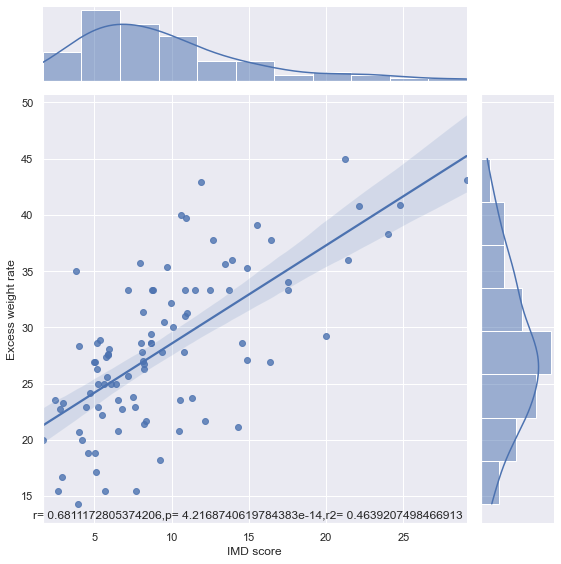

In [15]:
from scipy import stats
dropped_df = merged_df.dropna()

measures = "r= {r},p= {p},r2= {r2}".format(r = stats.pearsonr(dropped_df['IMD score'], dropped_df['Excess weight rate'])[0], p = stats.pearsonr(dropped_df['IMD score'], dropped_df['Excess weight rate'])[1], r2 = stats.pearsonr(dropped_df['IMD score'], dropped_df['Excess weight rate'])[0] ** 2)

sns.set(style="darkgrid", color_codes=True)
j = sns.jointplot('IMD score', 'Excess weight rate', data = dropped_df, kind='reg', height=8)
j.ax_joint.text(x=1.0,y=13.0,s=measures)
plt.show()

It looks like there is a positive relationship between poverty and obesity in Buckinghamshire. The higher the IMD score for a ward, i.e. the rate of poverty, the higher the rate of excess weight among Year 6 age children. With an r^2 of 0.46 and a p value of 4.2e-14, the effect is mild but satistically significant. The public health department is right to focus on poverty. Not only does the approach target areas where people may be restricted in having healthier lives, it also targets areas which are more likely to have a higher rate of obesity.

## Retrieving the Foursquare data

Next, I used the Foursquare API to get the top 100 venues for each ward within a radius of 2500 metres (the radius had to be this big as some wards were quite large).

In [16]:
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize

In [17]:
CLIENT_ID = 'O0F25I3IWQPWWEPH1AHAPPUJWKXEL5XAROSV0C5TOBY0ZU3B' # your Foursquare ID
CLIENT_SECRET = 'AX2SHJZIK5NV1UTDZNWCAAWG3M445ZA3MNKJXEY5WG22IPGW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [18]:
# Creating function that gets the top 100 venues that are in each neighborhood within a radius of 2500 meters.
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
bucks_venues = getNearbyVenues(names=bucks_df['Ward Name'],
                                   latitudes=bucks_df['latitude'],
                                   longitudes=bucks_df['longitude']
                                  )

Ballinger, South Heath and Chartridge
Buckingham South
Central & Walton
Coldharbour
Central
Edlesborough
Chalfont Common
Elmhurst
Chalfont St Giles
Gatehouse
Chesham Bois and Weedon Hill
Great Brickhill & Newton Longville
Cholesbury, The Lee and Bellingdon
Great Horwood
Gold Hill
Great Missenden
Grendon Underwood & Brill
Haddenham & Stone
Hilltop and Townsend
Long Crendon
Holmer Green
Luffield Abbey
Little Chalfont
Mandeville & Elm Farm
Little Missenden
Marsh Gibbon
Newtown
Oakfield & Bierton
Penn and Coleshill
Oakley
Prestwood and Heath End
Pitstone & Cheddington
Ridgeway
St Mary's and Waterside
Seer Green
Vale
Abbey
Bledlow and Bradenham
Booker and Cressex
Bourne End-cum-Hedsor
Bowerdean
Chiltern Rise
Disraeli
Downley and Plomer Hill
Flackwell Heath and Little Marlow
Greater Hughenden
Greater Marlow
Hambleden Valley
Hazlemere North
Hazlemere South
Icknield
Lacey Green, Speen and the Hampdens
Marlow North and West
Marlow South East
Micklefield
Oakridge and Castlefield
Ryemead
Sands
St

I then grouped this data, so that I had the count of venues in each category of venue, per ward.

In [20]:
# one hot encoding
bucks_onehot = pd.get_dummies(bucks_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bucks_onehot['Neighborhood'] = bucks_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bucks_onehot.columns[-1]] + list(bucks_onehot.columns[:-1])
bucks_onehot = bucks_onehot[fixed_columns]

In [21]:
bucks_grouped = bucks_onehot.groupby('Neighborhood').sum().reset_index()
bucks_grouped

,Neighborhood,African Restaurant,Airport,Alternative Healer,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Turkish Restaurant,Veterinarian,Video Game Store,Warehouse Store,Water Park,Windmill,Wine Shop,Winery,Wings Joint,Zoo
0,Abbey,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,Amersham Common,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
2,Amersham Town,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,Amersham-on-the-Hill,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
4,Asheridge Vale and Lowndes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Wendover & Halton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,Wexham & Fulmer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,Wing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,Wingrave,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I then grouped this data again to get an overall total for venues per ward, a total for what I identify as healthy venues and a total for unhealthy venues.

In [22]:
bucks_grouped['Total'] = bucks_grouped.loc[:, bucks_grouped.columns != 'Neighborhood'].sum(axis=1)

In [23]:
bucks_grouped['Total healthy'] = bucks_grouped[['Athletics & Sports',
'Cave',
'Forest',
'Fruit & Vegetable Store',
'Garden',
'Golf Course',
'Gym',
'Gym / Fitness Center',
'Gym Pool',
'Hill',
'Indoor Play Area',
'Lake',
'Martial Arts School',
'Other Great Outdoors',
'Outdoors & Recreation',
'Park',
'Playground',
'Pool',
'Recreation Center',
'River',
'Scenic Lookout',
'Soccer Field',
'Sports Club',
'Squash Court',
'Stables',
'Tennis Court',
'Trail',
'Water Park']].sum(axis=1)

In [24]:
bucks_grouped['Total unhealthy'] = bucks_grouped[['American Restaurant',
'BBQ Joint',
'Burger Joint',
'Burrito Place',
'Chinese Restaurant',
'Dessert Shop',
'Diner',
'Donut Shop',
'English Restaurant',
'Fast Food Restaurant',
'Fish & Chips Shop',
'Food Truck',
'Indian Restaurant',
'Turkish Restaurant',
'Noodle House',
'Pizza Place',
'Pub',
'Steakhouse']].sum(axis=1)

I then converted the healthy and unhealthy totals into a rate (% of total venues), in order to control for overall population/venue density.

In [25]:
bucks_grouped['Total unhealthy'] = bucks_grouped['Total unhealthy']/bucks_grouped['Total']*100

In [26]:
bucks_grouped['Total healthy'] = bucks_grouped['Total healthy']/bucks_grouped['Total']*100
bucks_grouped

,Neighborhood,African Restaurant,Airport,Alternative Healer,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Warehouse Store,Water Park,Windmill,Wine Shop,Winery,Wings Joint,Zoo,Total,Total healthy,Total unhealthy
0,Abbey,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,64,12.500000,25.000000
1,Amersham Common,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,26,3.846154,23.076923
2,Amersham Town,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,29,3.448276,20.689655
3,Amersham-on-the-Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,36,2.777778,25.000000
4,Asheridge Vale and Lowndes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,20,25.000000,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Wendover & Halton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12,25.000000,16.666667
94,Wexham & Fulmer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,14,21.428571,7.142857
95,Wing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,20.000000,80.000000
96,Wingrave,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,50.000000,0.000000


I then merged all my variables for each ward into one dataframe.

In [27]:
final_df = bucks_grouped[['Neighborhood','Total healthy','Total unhealthy']]
final_df.columns = ['Ward Name', 'Total healthy', 'Total unhealthy']

In [28]:
final_df = pd.merge(merged_df,final_df)

In [29]:
final_df.drop(['Ward ID','longitude','latitude'], axis=1, inplace=True)

In [30]:
final_df.dropna(inplace=True)
final_df

,Ward Name,IMD score,Excess weight rate,Total healthy,Total unhealthy
0,"Ballinger, South Heath and Chartridge",7.687,15.4,40.000000,0.000000
1,Buckingham South,5.163,26.3,6.666667,13.333333
2,Central & Walton,12.502,33.3,6.756757,21.621622
3,Coldharbour,9.723,35.4,5.633803,28.169014
4,Central,4.978,26.9,13.333333,10.000000
...,...,...,...,...,...
93,Gerrards Cross,5.948,28.1,8.000000,8.000000
94,Iver Heath,10.579,40.0,11.538462,30.769231
95,Iver Village & Richings Park,11.884,42.9,37.500000,25.000000
96,Stoke Poges,8.689,28.6,15.789474,15.789474


## Testing venues and obesity

As a bit of exploratory data analysis, I wanted to check if the rate of healthy/unhealthy venues had any correlation with the rate of excess weight. I could feed this back to the public health department to advise whether the approach to focus on venues is an effective one.

C:\Users\willi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


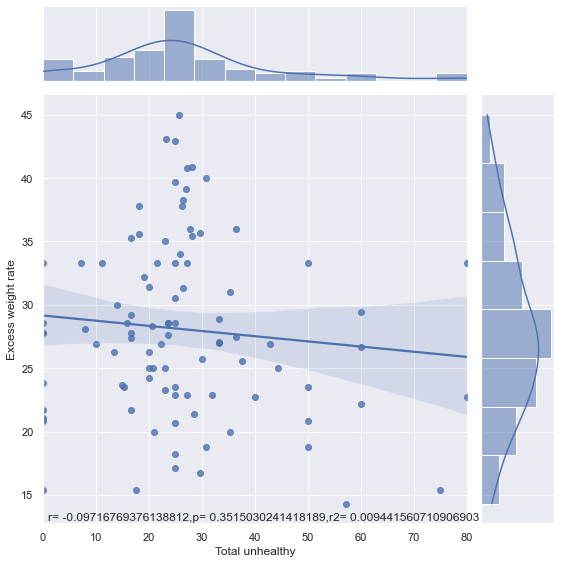

In [31]:
measures2 = "r= {r},p= {p},r2= {r2}".format(r = stats.pearsonr(final_df['Total unhealthy'], final_df['Excess weight rate'])[0], p = stats.pearsonr(final_df['Total unhealthy'], final_df['Excess weight rate'])[1], r2 = stats.pearsonr(final_df['Total unhealthy'], final_df['Excess weight rate'])[0] ** 2)

unhealth = sns.jointplot('Total unhealthy', 'Excess weight rate', data = final_df, kind='reg', height=8)
unhealth.ax_joint.text(x=1.0,y=13.0,s=measures2)
plt.show()

C:\Users\willi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


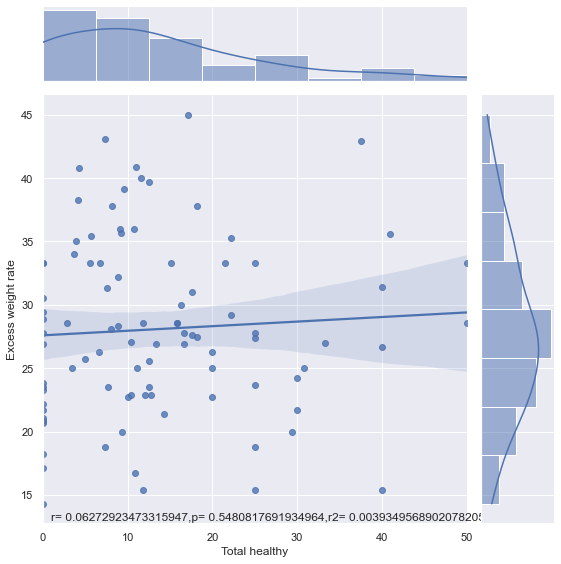

In [32]:
measures3 = "r= {r},p= {p},r2= {r2}".format(r = stats.pearsonr(final_df['Total healthy'], final_df['Excess weight rate'])[0], p = stats.pearsonr(final_df['Total healthy'], final_df['Excess weight rate'])[1], r2 = stats.pearsonr(final_df['Total healthy'], final_df['Excess weight rate'])[0] ** 2)

health = sns.jointplot('Total healthy', 'Excess weight rate', data = final_df, kind='reg', height=8)
health.ax_joint.text(x=1.0,y=13.0,s=measures3)
plt.show()

Unlike poverty and obesity, there did not appear to be any relationship between unhealthy/healthy venues. I will continue to use this data in my clustering model, but taking this project further I may consider using different data.

## Clustering the wards

Finally, I produced my kmeans clusters. First I used yellowbrick for applying the elbow method for identify the optimal value for k.

In [33]:
!pip install yellowbrick
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import numpy as np
from yellowbrick.cluster import KElbowVisualizer

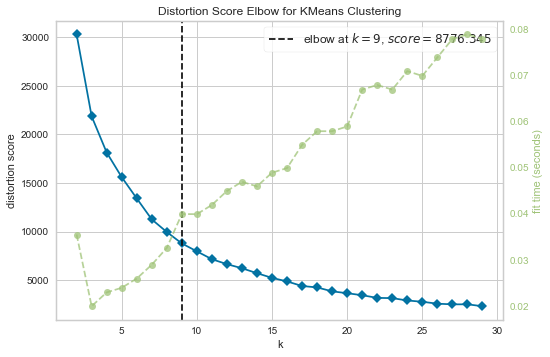

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
bucks_grouped_clustering = final_df.drop('Ward Name', 1)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(bucks_grouped_clustering)        # Fit data to visualizer
visualizer.show()

I then used sklearn to produce a kmeans model with a value of 8 for k.

In [35]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bucks_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 5, 3, 3, 5, 6, 7, 3, 7, 3])

In [36]:
# add clustering labels
final_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [37]:
final_df = pd.merge(final_df,merged_df[['Ward Name','latitude','longitude']])
final_df

,Cluster Labels,Ward Name,IMD score,Excess weight rate,Total healthy,Total unhealthy,latitude,longitude
0,4,"Ballinger, South Heath and Chartridge",7.687,15.4,40.000000,0.000000,51.71306,-0.67319
1,5,Buckingham South,5.163,26.3,6.666667,13.333333,51.99219,-0.97332
2,3,Central & Walton,12.502,33.3,6.756757,21.621622,51.81117,-0.80040
3,3,Coldharbour,9.723,35.4,5.633803,28.169014,51.81315,-0.83723
4,5,Central,4.978,26.9,13.333333,10.000000,51.60405,-0.54285
...,...,...,...,...,...,...,...,...
89,5,Gerrards Cross,5.948,28.1,8.000000,8.000000,51.58500,-0.56235
90,3,Iver Heath,10.579,40.0,11.538462,30.769231,51.53985,-0.51430
91,0,Iver Village & Richings Park,11.884,42.9,37.500000,25.000000,51.51195,-0.52161
92,0,Stoke Poges,8.689,28.6,15.789474,15.789474,51.54336,-0.58652


I then visualised the clusters in a Folium map.

In [38]:
# create map
map_clusters = folium.Map(location=[51.7619, -0.8], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_df['latitude'], final_df['longitude'], final_df['Ward Name'], final_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the clusters

### Cluster 1

In [39]:
cluster1 = final_df.loc[final_df['Cluster Labels'] == 0, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster1

,Ward Name,IMD score,Excess weight rate,Total healthy,Total unhealthy,latitude,longitude
12,Great Horwood,8.194,26.3,20.000000,20.000000,51.99588,-0.87321
13,Gold Hill,6.372,25.0,30.769231,23.076923,51.60182,-0.58628
17,Hilltop and Townsend,5.861,27.6,17.647059,23.529412,51.71150,-0.59280
25,Newtown,10.777,27.8,16.666667,16.666667,51.71945,-0.59500
29,Prestwood and Heath End,4.742,24.2,30.000000,20.000000,51.69104,-0.73757
31,Ridgeway,20.015,29.2,22.222222,16.666667,51.72220,-0.61811
33,Vale,14.847,35.3,22.222222,16.666667,51.72319,-0.61058
36,Booker and Cressex,16.366,26.9,16.666667,22.222222,51.61810,-0.79637
37,Bourne End-cum-Hedsor,5.160,28.6,15.789474,23.684211,51.57608,-0.70497
70,Asheridge Vale and Lowndes,11.288,23.7,25.000000,15.000000,51.71611,-0.62643


In [40]:
cluster1_mean = cluster1[['IMD score','Excess weight rate','Total healthy','Total unhealthy']].mean()
print(cluster1_mean)

IMD score             10.373647
Excess weight rate    29.388235
Total healthy         21.833087
Total unhealthy       18.485122
dtype: float64


### Cluster 2

In [41]:
cluster2 = final_df.loc[final_df['Cluster Labels'] == 1, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster2

,Ward Name,IMD score,Excess weight rate,Total healthy,Total unhealthy,latitude,longitude
35,Bledlow and Bradenham,8.227,26.7,40.0,60.0,51.69051,-0.84739
39,Chiltern Rise,11.535,33.3,0.0,80.0,51.62756,-0.84076
48,"Lacey Green, Speen and the Hampdens",5.681,15.4,25.0,75.0,51.70715,-0.79751
79,Wing,6.777,22.7,20.0,80.0,51.89771,-0.74354


In [42]:
cluster2_mean = cluster2[['IMD score','Excess weight rate','Total healthy','Total unhealthy']].mean()
print(cluster2_mean)

IMD score              8.055
Excess weight rate    24.525
Total healthy         21.250
Total unhealthy       73.750
dtype: float64


### Cluster 3

In [43]:
cluster3 = final_df.loc[final_df['Cluster Labels'] == 2, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster3

,Ward Name,IMD score,Excess weight rate,Total healthy,Total unhealthy,latitude,longitude
23,Little Missenden,5.067,18.8,25.000000,50.000000,51.68734,-0.66068
27,Penn and Coleshill,5.215,25.0,11.111111,44.444444,51.63614,-0.64752
41,Downley and Plomer Hill,4.173,20.0,29.411765,35.294118,51.65089,-0.77972
42,Flackwell Heath and Little Marlow,5.828,25.6,12.500000,37.500000,51.59131,-0.73091
43,Greater Hughenden,2.785,22.7,10.000000,40.000000,51.67074,-0.75245
47,Icknield,7.147,33.3,25.000000,50.000000,51.74826,-0.81857
61,Aston Clinton & Stoke Mandeville,5.900,27.5,18.181818,36.363636,51.79669,-0.71237
81,Winslow,8.151,27.0,33.333333,33.333333,51.95815,-0.93650
87,Denham,10.870,31.0,17.647059,35.294118,51.57582,-0.50595


In [44]:
cluster3_mean = cluster3[['IMD score','Excess weight rate','Total healthy','Total unhealthy']].mean()
print(cluster3_mean)

IMD score              6.126222
Excess weight rate    25.655556
Total healthy         20.242787
Total unhealthy       40.247739
dtype: float64


### Cluster 4

In [45]:
cluster4 = final_df.loc[final_df['Cluster Labels'] == 3, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster4

,Ward Name,IMD score,Excess weight rate,Total healthy,Total unhealthy,latitude,longitude
2,Central & Walton,12.502,33.3,6.756757,21.621622,51.81117,-0.80040
3,Coldharbour,9.723,35.4,5.633803,28.169014,51.81315,-0.83723
7,Elmhurst,23.976,38.3,4.166667,26.388889,51.82395,-0.80709
9,Gatehouse,22.140,40.8,4.285714,27.142857,51.82684,-0.82722
20,Luffield Abbey,13.702,33.3,0.000000,25.000000,52.04133,-0.96118
22,Mandeville & Elm Farm,9.954,32.2,8.823529,19.117647,51.80264,-0.80127
26,Oakfield & Bierton,9.512,30.5,0.000000,25.000000,51.83279,-0.77304
32,St Mary's and Waterside,14.527,28.6,11.764706,23.529412,51.69918,-0.60761
34,Abbey,10.929,39.7,12.500000,25.000000,51.62384,-0.76133
38,Bowerdean,16.430,37.8,8.196721,26.229508,51.63354,-0.73317


In [46]:
cluster4_mean = cluster4[['IMD score','Excess weight rate','Total healthy','Total unhealthy']].mean()
print(cluster4_mean)

IMD score             14.952087
Excess weight rate    35.930435
Total healthy          8.194077
Total unhealthy       26.591776
dtype: float64


### Cluster 5

In [47]:
cluster5 = final_df.loc[final_df['Cluster Labels'] == 4, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster5

,Ward Name,IMD score,Excess weight rate,Total healthy,Total unhealthy,latitude,longitude
0,"Ballinger, South Heath and Chartridge",7.687,15.4,40.000000,0.000000,51.71306,-0.67319
30,Pitstone & Cheddington,8.066,27.8,25.000000,0.000000,51.83812,-0.63208
54,Sands,13.431,35.6,40.909091,18.181818,51.63081,-0.79817
55,Stokenchurch and Radnage,8.117,31.4,40.000000,20.000000,51.65224,-0.88200
64,Quainton,8.000,28.6,50.000000,0.000000,51.89568,-0.89829
75,Waddesdon,8.356,21.7,30.000000,0.000000,51.82903,-0.92667
80,Wingrave,10.838,33.3,50.000000,0.000000,51.87153,-0.67749


In [48]:
cluster5_mean = cluster5[['IMD score','Excess weight rate','Total healthy','Total unhealthy']].mean()
print(cluster5_mean)

IMD score              9.213571
Excess weight rate    27.685714
Total healthy         39.415584
Total unhealthy        5.454545
dtype: float64


### Cluster 6

In [49]:
cluster6 = final_df.loc[final_df['Cluster Labels'] == 5, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster6

,Ward Name,IMD score,Excess weight rate,Total healthy,Total unhealthy,latitude,longitude
1,Buckingham South,5.163,26.3,6.666667,13.333333,51.99219,-0.97332
4,Central,4.978,26.9,13.333333,10.000000,51.60405,-0.54285
15,Grendon Underwood & Brill,14.266,21.1,0.000000,0.000000,51.85657,-1.02017
24,Marsh Gibbon,10.480,20.8,0.000000,0.000000,51.93364,-1.03320
63,Buckingham North,8.729,33.3,5.555556,11.111111,52.00450,-0.98864
72,Steeple Claydon,9.375,27.8,0.000000,0.000000,51.93479,-0.96444
73,Stewkley,7.516,23.8,0.000000,0.000000,51.90983,-0.80462
74,Tingewick,12.181,21.7,0.000000,16.666667,51.99887,-1.04970
89,Gerrards Cross,5.948,28.1,8.000000,8.000000,51.58500,-0.56235


In [50]:
cluster6_mean = cluster6[['IMD score','Excess weight rate','Total healthy','Total unhealthy']].mean()
print(cluster6_mean)

IMD score              8.737333
Excess weight rate    25.533333
Total healthy          3.728395
Total unhealthy        6.567901
dtype: float64


### Cluster 7

In [51]:
cluster7 = final_df.loc[final_df['Cluster Labels'] == 6, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster7

,Ward Name,IMD score,Excess weight rate,Total healthy,Total unhealthy,latitude,longitude
5,Edlesborough,6.522,23.5,12.500000,25.000000,51.85232,-0.60335
10,Chesham Bois and Weedon Hill,1.671,20.0,9.302326,20.930233,51.68581,-0.61766
14,Great Missenden,2.674,15.4,11.764706,17.647059,51.70189,-0.70800
18,Long Crendon,4.017,20.7,0.000000,25.000000,51.78514,-0.99910
21,Little Chalfont,5.352,28.9,0.000000,33.333333,51.66965,-0.56521
44,Greater Marlow,5.124,17.1,0.000000,25.000000,51.58383,-0.80444
45,Hazlemere North,2.433,23.5,7.692308,15.384615,51.65442,-0.71587
46,Hazlemere South,2.956,23.3,0.000000,23.076923,51.64929,-0.70639
49,Marlow North and West,5.251,22.9,10.416667,25.000000,51.57065,-0.78134
50,Marlow South East,7.633,22.9,12.727273,27.272727,51.57290,-0.76474


In [52]:
cluster7_mean = cluster7[['IMD score','Excess weight rate','Total healthy','Total unhealthy']].mean()
print(cluster7_mean)

IMD score              5.186053
Excess weight rate    22.305263
Total healthy          6.784333
Total unhealthy       25.268752
dtype: float64


### Cluster 8

In [53]:
cluster8 = final_df.loc[final_df['Cluster Labels'] == 7, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster8

,Ward Name,IMD score,Excess weight rate,Total healthy,Total unhealthy,latitude,longitude
6,Chalfont Common,5.472,22.2,0.0,60.000000,51.62648,-0.54545
8,Chalfont St Giles,3.915,14.3,0.0,57.142857,51.63528,-0.57193
11,Great Brickhill & Newton Longville,8.665,29.4,0.0,60.000000,51.94994,-0.75180
16,Haddenham & Stone,6.506,20.8,0.0,50.000000,51.78136,-0.88985
19,Holmer Green,5.010,26.9,0.0,42.857143,51.66905,-0.68838
28,Oakley,10.522,23.5,0.0,50.000000,51.79467,-1.07500


In [54]:
cluster8_mean = cluster8[['IMD score','Excess weight rate','Total healthy','Total unhealthy']].mean()
print(cluster8_mean)

IMD score              6.681667
Excess weight rate    22.850000
Total healthy          0.000000
Total unhealthy       53.333333
dtype: float64


I then brought these clusters together in one data frame, to compare the mean value for each variable between clusters.

In [55]:
c1 = cluster1_mean.to_frame()
c1.columns = [1]
c2 = cluster2_mean.to_frame()
c2.columns = [2]
c3 = cluster3_mean.to_frame()
c3.columns = [3]
c4 = cluster4_mean.to_frame()
c4.columns = [4]
c5 = cluster5_mean.to_frame()
c5.columns = [5]
c6 = cluster6_mean.to_frame()
c6.columns = [6]
c7 = cluster7_mean.to_frame()
c7.columns = [7]
c8 = cluster8_mean.to_frame()
c8.columns = [8]
result = pd.concat([c1, c2, c3, c4, c5, c6, c7, c8], axis=1)
result = result.T
result

,IMD score,Excess weight rate,Total healthy,Total unhealthy
1,10.373647,29.388235,21.833087,18.485122
2,8.055000,24.525000,21.250000,73.750000
3,6.126222,25.655556,20.242787,40.247739
4,14.952087,35.930435,8.194077,26.591776
5,9.213571,27.685714,39.415584,5.454545
6,8.737333,25.533333,3.728395,6.567901
7,5.186053,22.305263,6.784333,25.268752
8,6.681667,22.850000,0.000000,53.333333


I then ranked each mean value for each variable for each cluster, the lower the number, the better a cluster ranked for each target variable. I then totalled the 4 ranks for each cluster using a stacked barchart. The cluster with lowest total rank would likely be the best candidate for the shortlist of potential locations for the centre.

In [56]:
ranks = result[['IMD score','Excess weight rate','Total unhealthy']].rank(ascending=False)
ranks['Total healthy'] = result['Total healthy'].rank(ascending=True)
ranks

,IMD score,Excess weight rate,Total unhealthy,Total healthy
1,2.0,2.0,6.0,7.0
2,5.0,6.0,1.0,6.0
3,7.0,4.0,3.0,5.0
4,1.0,1.0,4.0,4.0
5,3.0,3.0,8.0,8.0
6,4.0,5.0,7.0,2.0
7,8.0,8.0,5.0,3.0
8,6.0,7.0,2.0,1.0


<AxesSubplot:ylabel='Cluster'>

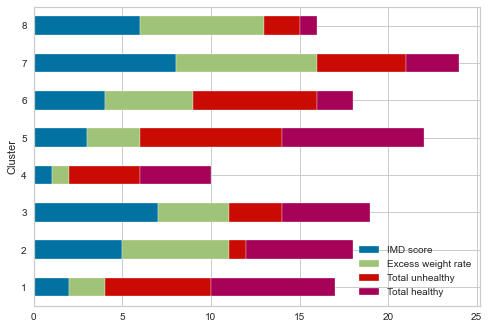

In [57]:
ranks.plot(kind='barh', stacked=True, xlabel='Cluster', ylabel='Cumulative rank')

## Discussion

Looking through the average features of each cluster, it looks the Cluster 3 is the most appropriate cluster to act as a shortlist of locations for the fitness and nutrition centre. Cluster 3 presents the highest average rate of obesity (as measured by the rate of excess weight among year 6 age children), the highest average rate of poverty (as measured by the IMD score), and has a higher number of unhealthy services than those that are healthy.

This means that Aylesbury and High Wycombe are optimal targets for the fitness and nutrition centre, because they contain wards in Cluster 3. Without any wards in Cluster 3, the towns of Chesham, Amersham, Buckingham and Gerrard Cross are not not optimal targets.

Cluster 1 also stands out as having a relatively high rate of obesity and poverty, but it also has a relatively high rate of healthy services and a low rate unhealthy services, making it less appropriate than cluster 3. Cluster 2 is notable for having the highest rate of unhealthy services, however it has a relatively low obesity and poverty rate compared to other clusters and so is also less appropriate as a shortlist of potential locations.

## Conclusion

Going back to the Public Health department with my cluster analysis results, I would suggest that Aylesbury and High Wycombe as the key targets for a new fitness and nutrition centre.

However, moving forward, I would suggest that we test various other metrics and factors to use in clustering Buckinghamshire wards, according to how impactful they are on obesity outcomes.